 - upsampling
 - resnet50
 - score - 
 - model1 - '/app/_data/models/res50ups.h5'
 - modell2 - '/app/_data/models/res50ups_60.h5' - 60epochs, callback early stopping
 - drop duplicates

In [1]:
import os

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")
# warnings.filterwarnings(action='once')

import matplotlib.pyplot as plt

%matplotlib inline
# plots
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    plot_confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential

# keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm

# from venn import venn

In [2]:
PATH = "/app/_data/"
BATCH_SIZE = 64
SEED = 1488
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 6
INPUT_SIZE = (224, 224, 3)
MODEL_PATH = "/app/_data/models/base_model_0005"
# SEED = 42
# MODEL_PATH = '/kaggle/input/base-resnet50-0001/app/_data/models/base_model_0001/'

In [3]:
labels = pd.read_csv(PATH + "train.csv")

In [4]:
sample_submission = pd.read_csv(PATH + "sample_submission.csv")

In [5]:
duplicates = pd.read_csv("/app/sandbox/duplicates_hash.csv", index_col=[0])

In [6]:
# labels.head()
# labels.info()

In [7]:
# labels["labels"].value_counts(normalize=True)

In [8]:
labels = labels.join(labels["labels"].str.get_dummies(sep=" "))

In [9]:
list_duplicates = duplicates["0"].tolist() + duplicates["1"].tolist()
labels = labels.query("image not in @list_duplicates")

In [10]:
labels.head(1)

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,healthy,0,0,1,0,0,0


In [11]:
# def resize_im(
#     image_name, new_folder_name="small_nearest", size=(224, 224), resample=Image.NEAREST
# ):
#     image = Image.open(PATH + "train_images/" + image_name)
#     image = image.resize(size, resample=resample)
#     if not os.path.isdir(PATH + "train_images/" + new_folder_name + "/"):
#         os.mkdir(PATH + "train_images/" + new_folder_name + "/")
#     image.save(PATH + "train_images/" + new_folder_name + "/" + image_name)


# labels['image'].apply(resize_im)

In [12]:
# for im1, im2 in duplicates.values:
#     plt.figure(figsize=(10,3))
#     plt.subplot(1,2,1)
#     plt.title(labels[labels['image'] == im1]['labels'].tolist())
#     plt.imshow(Image.open(PATH + "train_images/small_bicubic/"+im1))
#     plt.subplot(1,2,2)
#     plt.title(labels[labels['image'] == im2]['labels'].tolist())
#     plt.imshow(Image.open(PATH + "train_images/small_bicubic/"+im2))
#     plt.show();
# plt.show();

In [13]:
feature_columns = labels.columns[2:].tolist()

In [14]:
labels.sample()
feature_columns

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
7973,b8034f9d48f09f2d.jpg,frog_eye_leaf_spot,0,1,0,0,0,0


['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [15]:
train_df, valid_df = train_test_split(
    labels, train_size=0.8, random_state=SEED, stratify=labels["labels"]
)

In [16]:
train_df[train_df["powdery_mildew"] == 1].shape[0]

1017

In [18]:
for col in feature_columns:
    print(col, train_df[train_df[col] == 1][col].sum())

complex 1699
frog_eye_leaf_spot 3479
healthy 3699
powdery_mildew 1017
rust 1605
scab 4565


In [20]:
powdery_mildew = (
    train_df[train_df["powdery_mildew"] == 1]
    .sample(
        n=(3000 - train_df[train_df["powdery_mildew"] == 1].shape[0]),
        replace=True,
        random_state=SEED,
    )
)
rust = (
    train_df[train_df["rust"] == 1]
    .sample(
        n=(3000 - train_df[train_df["rust"] == 1].shape[0]),
        replace=True,
        random_state=SEED,
    )
)
complex_df = (
    train_df[train_df["complex"] == 1]
    .sample(
        n=(3000 - train_df[train_df["complex"] == 1].shape[0]),
        replace=True,
        random_state=SEED,
    )
)

In [21]:
train_df_new = pd.concat(
    [
        train_df,
        powdery_mildew,
        rust,
        complex_df,
    ],axis=0,ignore_index=True, 
)

In [22]:
train_df_new.shape
train_df.shape

(19504, 8)

(14825, 8)

In [23]:
train_datagen = ImageDataGenerator(
#     validation_split=0.2,
    rescale=1.0 / 255,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    brightness_range=(0.5, 1.5),
    shear_range=45,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
)
train = train_datagen.flow_from_dataframe(
    dataframe=train_df_new,
    directory=PATH + "train_images/small_bicubic/",
    x_col="image",
    y_col=feature_columns,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="training",
    seed=SEED,
    interpolation="bicubic",
)

Found 19504 validated image filenames.


In [29]:
valid_datagen = ImageDataGenerator(
    validation_split=0.9999999,
    rescale=1.0 / 255,
    #     samplewise_center=True,
    #     samplewise_std_normalization=True,
    #     rotation_range=45,
    #     width_shift_range=0.25,
    #     height_shift_range=0.25,
    #     brightness_range=(0.5, 1.5),
    #     shear_range=45,
    #     zoom_range=0.25,
    #     horizontal_flip=True,
    #     vertical_flip=True,
)
valid = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=PATH + "train_images/small_bicubic/",
    x_col="image",
    y_col=feature_columns,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="validation",
    seed=SEED,
    classes=feature_columns,
    interpolation="bicubic",
)

Found 3706 validated image filenames.


In [30]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH + "test_images/",
    x_col="image",
    y_col=None,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=None,
    seed=SEED,
    shuffle=False,
    interpolation="bicubic",
)

Found 3 validated image filenames.


In [20]:
# feat = next(test)
# plt.figure(figsize=(10, 10))
# for i in range(1, 4):
#     image = feat[i - 1]
#     #     label = target[i - 1]
#     plt.subplot(1, 3, i)
#     plt.imshow(image)
#     #     plt.xlabel(label)
#     plt.xticks([])
#     plt.yticks([])
#     plt.tight_layout()
# plt.show();

In [21]:
# valid._targets

In [22]:
# features, target = next(train)
# plt.figure(figsize=(10, 10))
# for i in range(1, 17):
#     image = features[i - 1]
#     label = target[i - 1]
#     plt.subplot(4, 4, i)
#     plt.imshow(image)
#     plt.xlabel(label)
#     plt.xticks([])
#     plt.yticks([])
#     plt.tight_layout()
# plt.show();

In [31]:
def plot_curves(model, loss=False):
    df = pd.DataFrame(model.history)
    if loss:
        plt.figure(figsize=(12, 6))
        plt.title("loss")
        plt.plot(df.iloc[:, 0], label="loss")
        plt.plot(df.iloc[:, 5], label="val_loss")
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=(12, 20))
        plt.subplot(4, 1, 1)
        plt.title("accuracy")
        plt.plot(df.iloc[:, 1], label="accuracy")
        plt.plot(df.iloc[:, 6], label="val_accuracy")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.title("recall")
        plt.plot(df.iloc[:, 2], label="recall")
        plt.plot(df.iloc[:, 7], label="val_recall")
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.title("precision")
        plt.plot(df.iloc[:, 3], label="precision")
        plt.plot(df.iloc[:, 8], label="val_precision")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.title("f1")
        plt.plot(df.iloc[:, 4], label="f1")
        plt.plot(df.iloc[:, 9], label="val_f1")
        plt.legend()
        plt.show();

In [62]:
# model = keras.models.load_model('/app/_data/models/base_model_0001/',
#                                 custom_objects={'loss':"binary_crossentropy",
#                                                 'acc': 'acc',
#                                                 'recall': keras.metrics.Recall(),
#                                                 'precision': keras.metrics.Precision(),
#                                                 'f1_score':tfa.metrics.F1Score(num_classes=6, average="micro")
#                                                }
#                                )

In [33]:
# data_augmentation = keras.Sequential(
#     [
#         keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#         keras.layers.experimental.preprocessing.RandomHeight(0.1),
#         keras.layers.experimental.preprocessing.RandomWidth(0.1),
#         keras.layers.experimental.preprocessing.RandomRotation(0.15),
#         keras.layers.experimental.preprocessing.RandomZoom(0.25, 0.25),
#     ]
# )

In [34]:
# tf.keras.mixed_precision.set_global_policy('mixed_float16')
# policy = keras.mixed_precision.experimental.Policy('mixed_float16')
# keras.mixed_precision.experimental.set_policy(policy)

In [35]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif 5 <= epoch < 20:
        return 0.0005
    else:
        return 0.0001

In [38]:
callbacks=[
        keras.callbacks.EarlyStopping(
            patience=5, restore_best_weights=True, verbose=1),
        keras.callbacks.LearningRateScheduler(schedule = scheduler, verbose=1)
        ]

In [39]:
backbone = ResNet50(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=6, activation="sigmoid"))
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=0.001),
    metrics=[
        "acc",
        keras.metrics.Recall(),
        keras.metrics.Precision(),
        tfa.metrics.F1Score(num_classes=6, average="micro"),
    ],
)

In [ ]:
history = model.fit(
    train,
    validation_data=valid,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
    callbacks = callbacks
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/50
305/305 [==============================] - 334s 1s/step - loss: 0.2538 - acc: 0.7069 - recall: 0.6115 - precision: 0.7786 - f1_score: 0.7046 - val_loss: 0.5436 - val_acc: 0.0640 - val_recall: 0.0553 - val_precision: 0.0775 - val_f1_score: 0.0655

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/50
305/305 [==============================] - 350s 1s/step - loss: 0.1941 - acc: 0.7860 - recall: 0.7243 - precision: 0.8330 - f1_score: 0.7799 - val_loss: 0.7288 - val_acc: 0.2369 - val_recall: 0.2138 - val_precision: 0.2389 - val_f1_score: 0.2275

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/50
305/305 [==============================] - 346s 1s/step - loss: 0.1783 - acc: 0.8011 - recall: 0.7517 - precision: 0.8433 - f1_score: 0.7947 - val_loss: 0.5211 - val_acc: 0.3713 - val_recall: 0.2299 - val_precision: 0.39

In [69]:
history_ups0 = pd.DataFrame(history.history)
history_ups0.to_csv("history_ups0.csv")

In [ ]:
model.save("/app/_data/models/res50ups.h5")

In [40]:
import shutil

In [41]:
# shutil.make_archive('base_model_0001_nearest', 'zip','/app/_data/models/base_model_0001/')

'/app/sandbox/base_model_0001_nearest.zip'

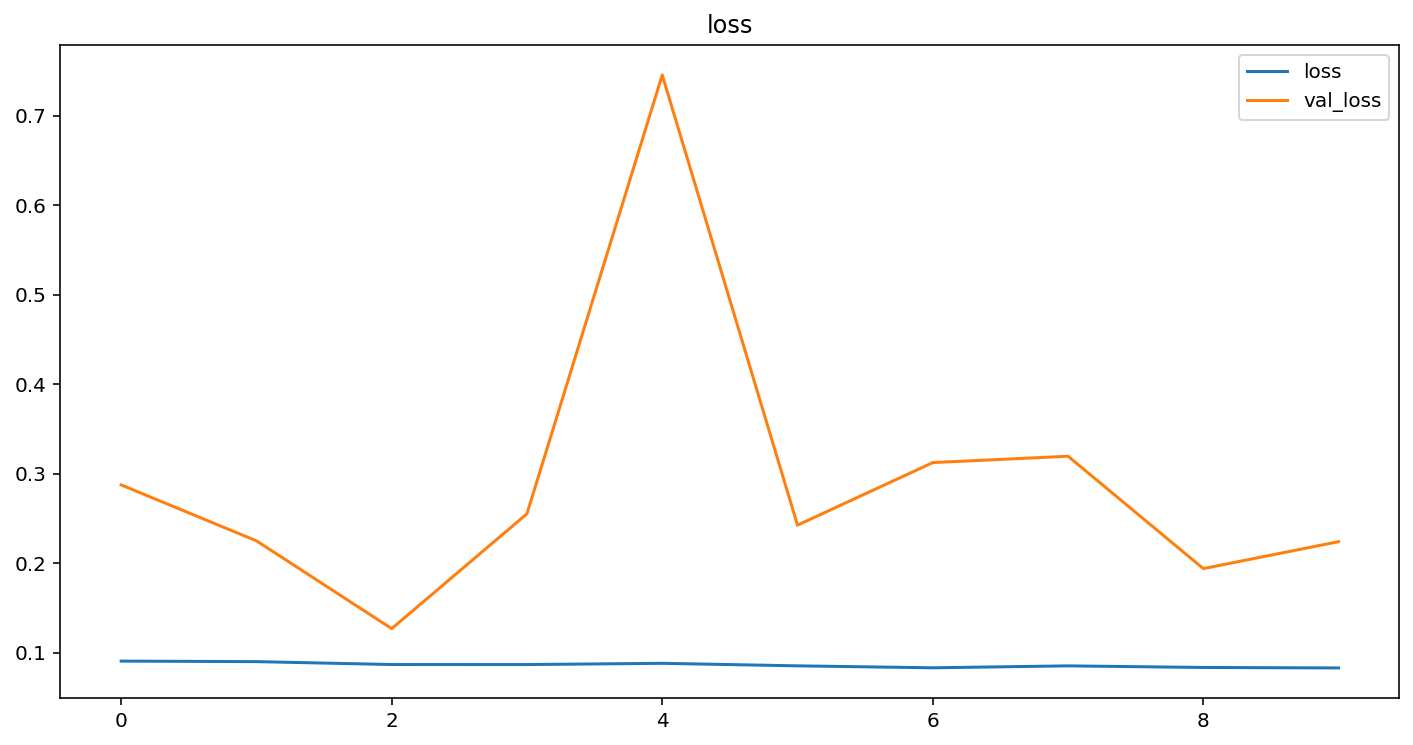

In [71]:
plot_curves(history, loss=True)

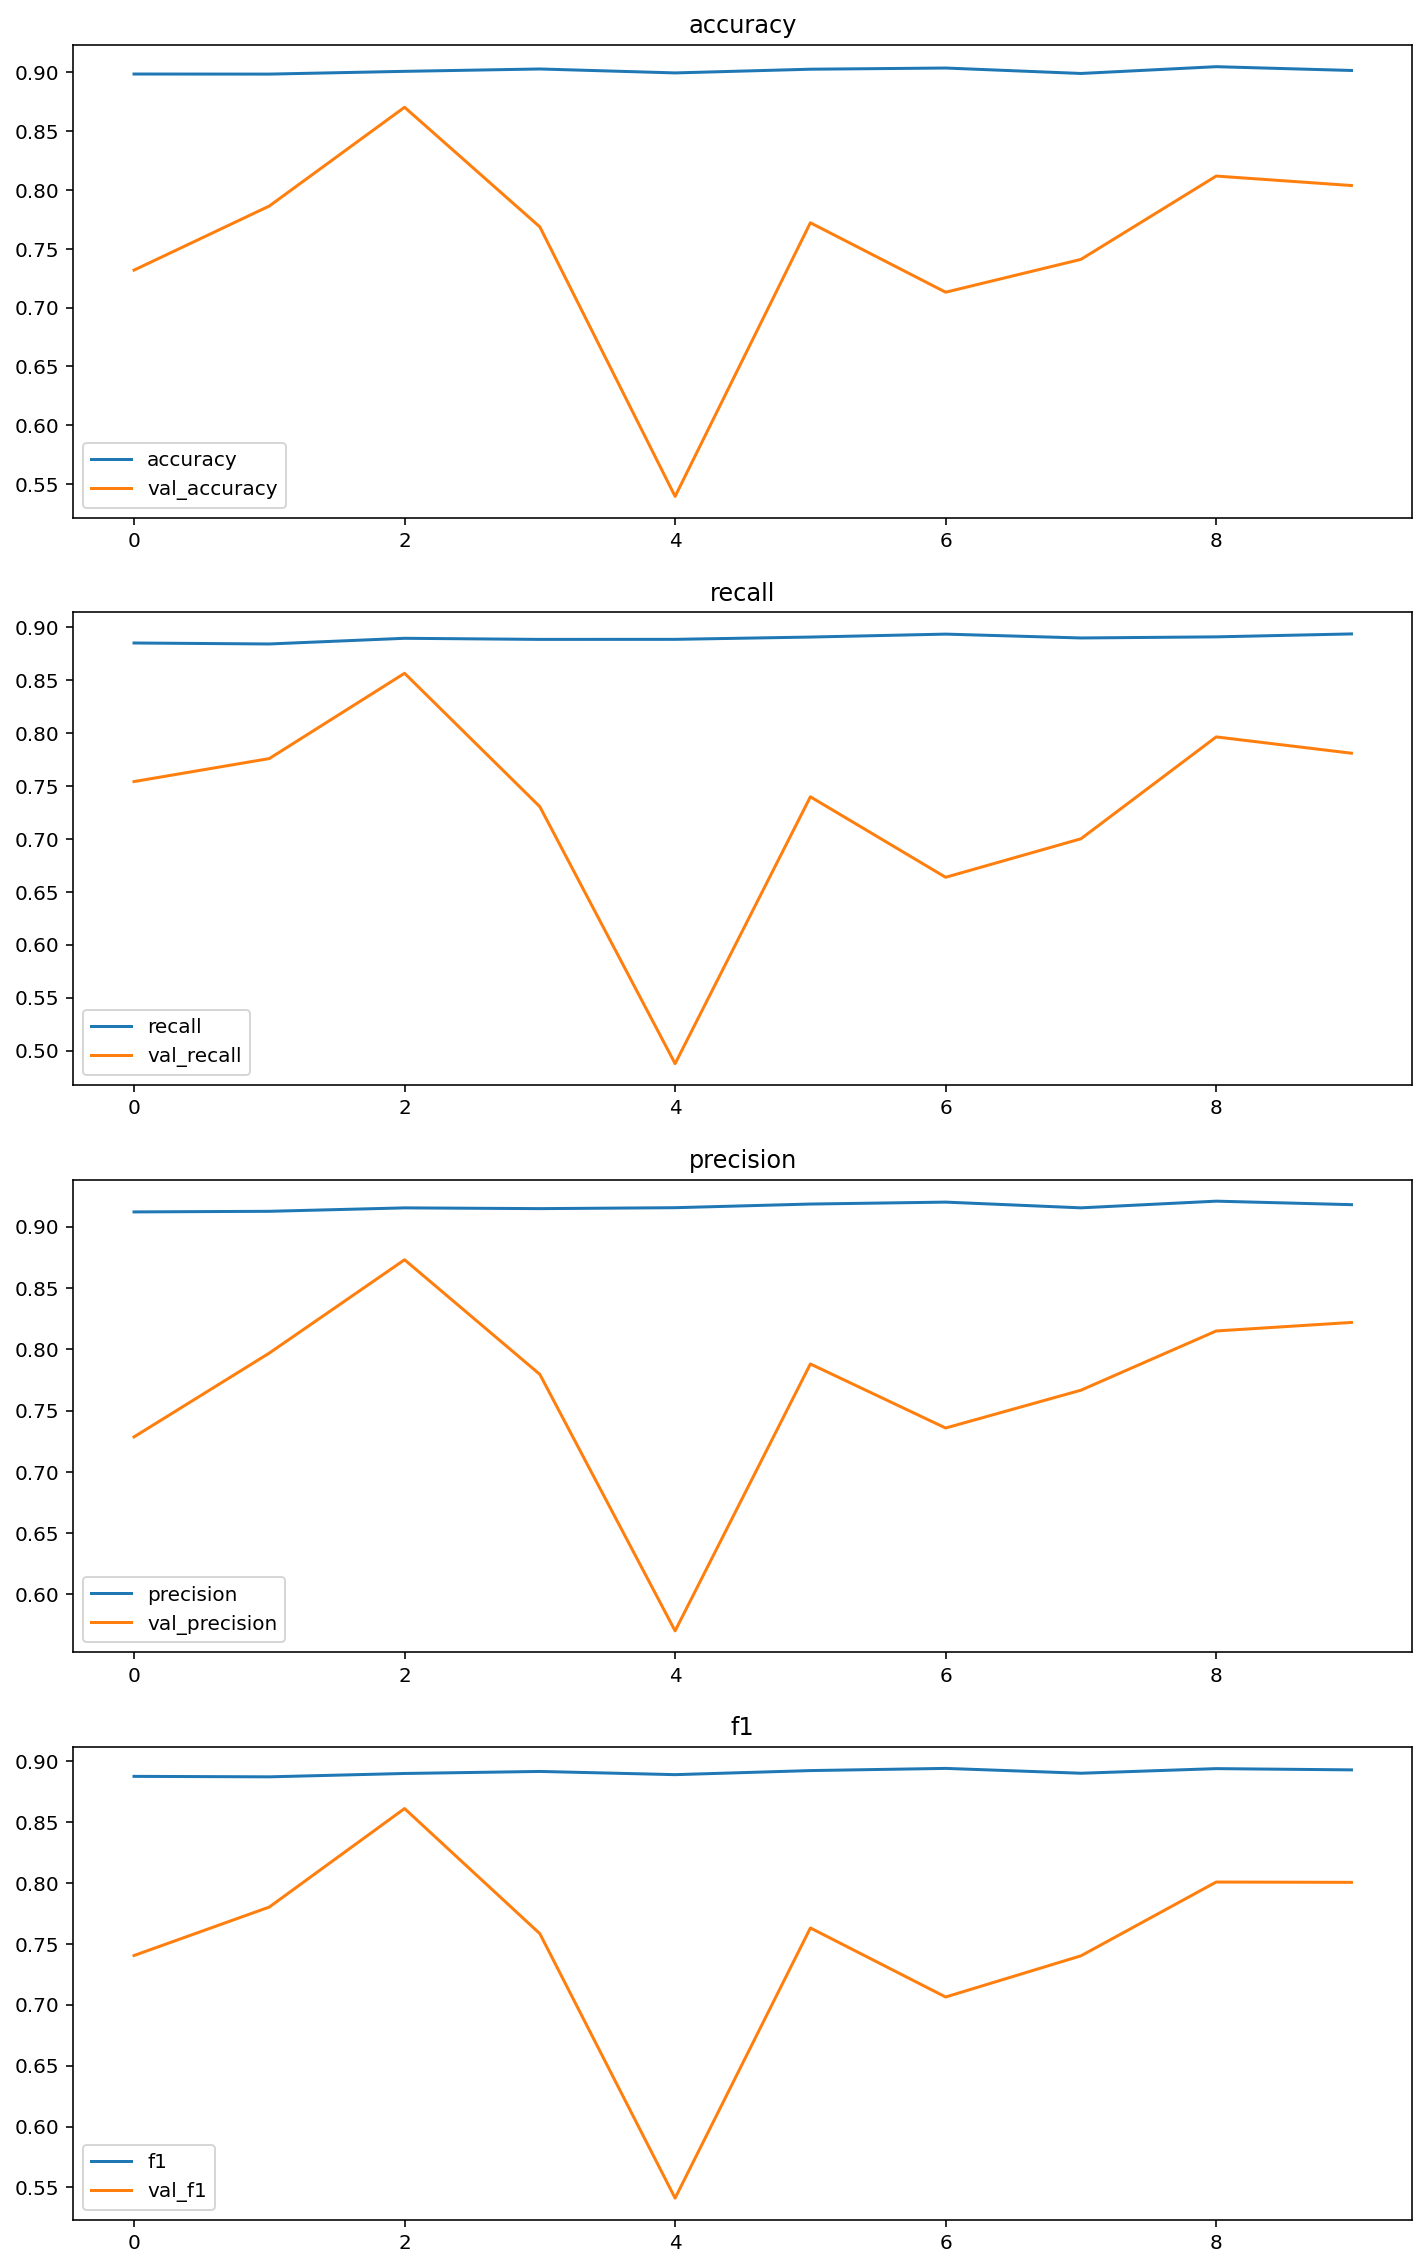

In [72]:
plot_curves(history)

In [28]:
prediction = model.predict(test)

In [30]:
test_sub = pd.DataFrame(prediction > 0.5, columns=feature_columns)
for name in test_sub.columns.tolist():
    test_sub[name] = test_sub[name].replace({True: name, False: ""})
test_sub["all"] = test_sub.apply(" ".join, axis=1).str.split().str.join(sep=" ")

In [31]:
test_sub

,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab,all
0,complex,,,,,,complex
1,,frog_eye_leaf_spot,,,,,frog_eye_leaf_spot
2,,,,,,,


In [32]:
model.evaluate(valid)

59/59 [==============================] - 8s 136ms/step - loss: 0.3497 - acc: 0.7968 - recall: 0.7617 - precision: 0.8225 - f1_score: 0.7917


[0.3497026562690735,
 0.7968330383300781,
 0.7616763710975647,
 0.822519063949585,
 0.791726291179657]

In [33]:
a = model.predict(valid)

In [34]:
# np.argmax(a[0])
a[3] > 0.5
valid._targets[3]

array([False, False, False, False, False,  True])

array([0, 0, 0, 0, 0, 1])

In [35]:
(a[555] > 0.5)
valid._targets[555]

array([False, False,  True, False, False, False])

array([0, 0, 0, 0, 1, 0])

In [37]:
valid_pred_0001 = pd.DataFrame(a, columns=feature_columns)
valid_pred_0001.to_csv("valid_pred_0001.csv")

In [38]:
train_pred_0005 = pd.DataFrame(model.predict(train), columns=feature_columns)
train_pred_0005.to_csv("train_pred_0005.csv")

In [26]:
d = [0, 0]
for i in np.linspace(0.01, 0.5, 100):
    b = sklearn.metrics.precision_recall_fscore_support(
        valid._targets, a > i, average="micro"
    )[2]
    if b > d[0]:
        d[0] = b
        d[1] = i

NameError: name 'a' is not defined

In [216]:
sklearn.metrics.precision_recall_fscore_support(
    valid._targets, a > 0.5, average="macro"
)[2]

0.12258990140768992

In [209]:
pd.DataFrame(history_100.history).to_csv("history_100.csv")

In [70]:
def f1(recall, precision):
    return 2 * ((precision * recall) / (precision + recall))

In [24]:
pd.DataFrame(history.history).tail(1)
pd.DataFrame(history.history).columns

,loss,categorical_accuracy,recall,precision,f1_score,val_loss,val_categorical_accuracy,val_recall,val_precision,val_f1_score
49,0.280581,0.922514,0.710095,0.954519,0.917384,0.539626,0.894257,0.628882,0.919528,0.889814


Index(['loss', 'categorical_accuracy', 'recall', 'precision', 'f1_score',
       'val_loss', 'val_categorical_accuracy', 'val_recall', 'val_precision',
       'val_f1_score'],
      dtype='object')

In [25]:
model.save("/app/_data/models/base_model", save_format="h5")